# Задание 5. Извлечение данных 

## Задание 5.1

Напишите скрипт, который скачивает  сообщения с Телеграм-канала https://t.me/Sputnik_results . Сохраните сообщения в формате по вашему выбору (.csv, .jsonl, sqlite, parquet, и т.д.). Откройте с помощью Pandas или аналогичных библиотек, постройте график числа сообщений в зависимости от даты. 

## Задание 5.2
1.Напишите функции для извлечения данных из сообщений:
   - пол участника
   - возраст участника

   Постройте диаграммы для визуализации. 

2.Реализуйте какой-либо анализ этих данных на ваше усмотрение. Например их можно кластеризовать и интерпретировать кластеры, или попробовать выделить статистику по среднему количеству антител в зависимости от возраста, или посчитать количество заболевших после вакцинации. Обязательна визуализация. 

# Задание 5.1

!pip install telethon

In [14]:
import configparser
import json

from telethon.sync import TelegramClient
from telethon import connection

# для корректного переноса времени сообщений в json
from datetime import date, datetime

# классы для работы с каналами
from telethon.tl.functions.channels import GetParticipantsRequest
from telethon.tl.types import ChannelParticipantsSearch

# класс для работы с сообщениями
from telethon.tl.functions.messages import GetHistoryRequest

# Считываем учетные данные
config = configparser.ConfigParser()
config.read("config.ini")

# Присваиваем значения внутренним переменным
api_id   = config['Telegram']['api_id']
api_hash = config['Telegram']['api_hash']
username = config['Telegram']['username']
client = TelegramClient(None, api_id, api_hash)
client.start()

<coroutine object AuthMethods._start at 0x000001922A781040>

In [ ]:
async def dump_all_messages(channel):
    """Записывает json-файл с информацией о всех сообщениях канала/чата"""
    offset_msg = 0    # номер записи, с которой начинается считывание
    limit_msg = 100   # максимальное число записей, передаваемых за один раз

    all_messages = []   # список всех сообщений
    total_messages = 0
    total_count_limit = 0  # поменяйте это значение, если вам нужны не все сообщения

    class DateTimeEncoder(json.JSONEncoder):
        '''Класс для сериализации записи дат в JSON'''
        def default(self, o):
            if isinstance(o, datetime):
                return o.isoformat()
            if isinstance(o, bytes):
                return list(o)
            return json.JSONEncoder.default(self, o)

    while True:
        history = await client(GetHistoryRequest(
            peer=channel,
            offset_id=offset_msg,
            offset_date=None, add_offset=0,
            limit=limit_msg, max_id=0, min_id=0,
            hash=0))
        if not history.messages:
            break
        messages = history.messages
        for message in messages:
            all_messages.append(message.to_dict())
        offset_msg = messages[len(messages) - 1].id
        total_messages = len(all_messages)
        if total_count_limit != 0 and total_messages >= total_count_limit:
            break

    with open('channel_messages.json', 'w', encoding='utf8') as outfile:
         json.dump(all_messages, outfile, ensure_ascii=False, cls=DateTimeEncoder)

import nest_asyncio
nest_asyncio.apply()

async def main():
    url = 'https://t.me/Sputnik_results'
    channel = await client.get_entity(url)
    await dump_all_messages(channel)


async with client:
    client.loop.run_until_complete(main())

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import json
import matplotlib.pyplot as plt
with open('channel_messages.json', encoding="UTF-8") as jsonfile:
    messages = json.load(jsonfile)
    jsonfile.close()

In [74]:
data = pd.DataFrame({"date":[], "message":[]})
for message in messages:
    if message['_'] == 'Message':
        data = data.append({"date": message["date"], "message": message['message']}, ignore_index = True)
data['date'] = pd.to_datetime(data["date"])
data['date'] = data['date'].dt.date

In [75]:
data.head()

,date,message
0,2023-01-15,Народные отчеты о вакцинации\n\n⚠️ ТОЛЬКО ПУБЛ...
1,2023-01-10,В этом можно только публиковать отчёты.\nЕсли ...
2,2023-01-10,"Здравствуйте \nПодскажите пожалуйста, куда нап..."
3,2023-01-02,"Ж, 20 лет, умеренный аллергик. Сделала Спутник..."
4,2022-12-31,"M40, без хронических болезней, в феврале 2022 ..."


Text(0, 0.5, 'number of messages')

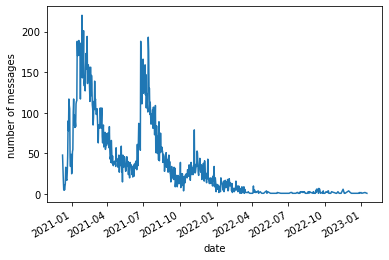

In [153]:
data.groupby('date').size().plot()
plt.gcf().autofmt_xdate()
plt.ylabel('number of messages')

# Задание 5.2.1

In [155]:
age_sex_info = pd.DataFrame({"sex": [],"age" : [], "message":[]})
for message in data['message']:
    info_all = re.findall(r"[МЖмж]+[.,]? ?\d{2}", message)
    if info_all != []:
        for info in info_all:
            sex = info[0]
            age = info[-2:]
            if sex == 'м':
                sex = 'М'
            elif sex == 'ж':
                sex = 'Ж'
            age_sex_info = age_sex_info.append({"sex":sex, "age":age, "message":message}, ignore_index = True)

In [156]:
age_sex_info.head()

,sex,age,message
0,Ж,20,"Ж, 20 лет, умеренный аллергик. Сделала Спутник..."
1,Ж,53,"#ревак #назально #спутник\n\nЖ53, ковидом не б..."
2,М,33,#назально #ревак #спутник-V\nМ33. 1 комп.: лег...
3,Ж,35,#назально #ревак. Ж35. Хр. Заболевания: полива...
4,М,13,#дети\nМ 13 лет. спутник м. \n1я доза 23.10.2...


Text(0, 0.5, 'number of participants')

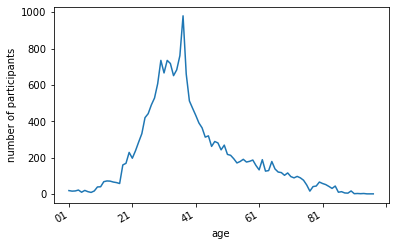

In [157]:
age_sex_info.groupby('age').size().plot()
plt.gcf().autofmt_xdate()
plt.ylabel('number of participants')

Text(0, 0.5, 'number of participants')

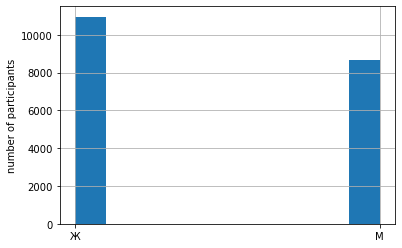

In [158]:
age_sex_info['sex'].hist()
plt.ylabel('number of participants')

# Задание 5.2.2

In [192]:
temp_info =  pd.DataFrame({"sex": [],"age" : [], "temp":[]})
for i, message in enumerate(age_sex_info['message']):
    temp_messages = re.findall(r"температура \d{2}[.,]?\d", message)
    if temp_messages!=[]:
        temp = temp_messages[0][-4:]
        if temp[2] == ',':
            temp = temp[:2] +'.' + temp[-1]
        temp_info = temp_info.append(
            {"sex":age_sex_info['sex'][i], 
             "age":age_sex_info['age'][i], 
             "temp":float(temp)}, ignore_index = True)

Text(0.5, 0, 'возраст')

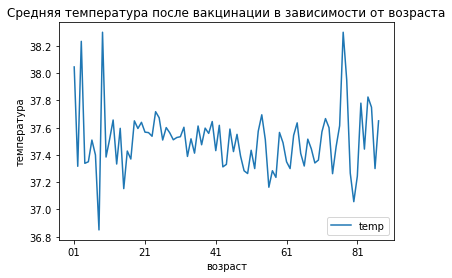

In [184]:
# temp_info.groupby('age').mean()().plot()
temp_info.groupby(['age']).mean().plot()
plt.title('Средняя температура после вакцинации в зависимости от возраста')
plt.ylabel('температура')
plt.xlabel('возраст')

Text(0.5, 0, 'возраст')

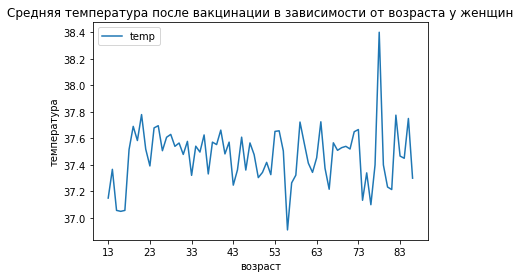

In [187]:
temp_info[temp_info['sex']=='Ж'].groupby(['age']).mean().plot()
plt.title('Средняя температура после вакцинации в зависимости от возраста у женщин')
plt.ylabel('температура')
plt.xlabel('возраст')

Text(0.5, 0, 'возраст')

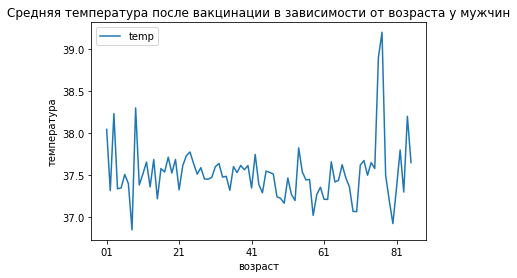

In [189]:
temp_info[temp_info['sex']=='М'].groupby(['age']).mean().plot()
plt.title('Средняя температура после вакцинации в зависимости от возраста у мужчин')
plt.ylabel('температура')
plt.xlabel('возраст')

In [197]:
temp_info['age'] = pd.to_numeric(temp_info['age'], downcast="integer")

In [213]:
df = {'10-19':[],'20-29':[],'30-39':[],'40-49':[],'50-59':[],'60-69':[],'70-79':[],'80-89':[]}
temps = np.zeros(8)
for i, age in enumerate(np.arange(10, 90, 10)):
    temps[i] = temp_info[(temp_info['age'] >= age) & (temp_info['age'] < age + 10)]['temp'].mean()

Text(0.5, 1.0, 'Средняя температура в зависимости от возраста по группам')

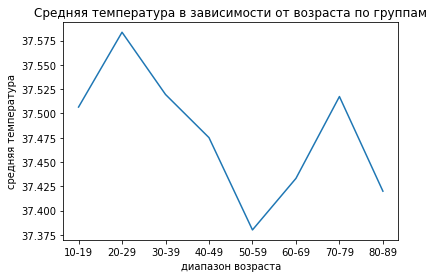

In [221]:
ages= ['10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89']
plt.plot(ages, temps)
plt.xlabel('диапазон возраста')
plt.ylabel('средняя температура')
plt.title('Средняя температура в зависимости от возраста по группам')